# Proyecto: Predicción de Alzheimer a partir de MRI usando Deep Learning




## **0. Integrantes del equipo de trabajo**
---
1. RAÚL RAMÍREZ PENAGOS
2. IVÁN QUEVEDO
3. LINA ÁVILA MORENO

## **1. Entendimiento y carga de los datos**

Es importante precisar que el Notebook inicial completo se subió en la fecha solicitada y se encuentra en la carpeta data del repositorio, solo estamos haciendo la partición para la carpeta de scripts.

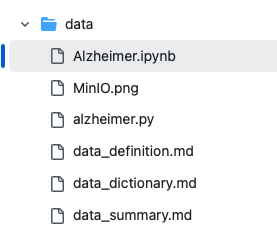

El conjunto de datos contiene 4 clases y etiquetas del 0 al 3:

1. Non demented : '0'
2. Very midly demented : '1'
3. Mildly demented : '2'
4. Moderately demented : '3'

In [ ]:
#pip install opencv-python
#!pip install tensorflow

In [1]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import hashlib
import matplotlib.cm as cm
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import random
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau



In [ ]:
#!pip install pyarrow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_train = pd.read_parquet('/content/drive/MyDrive/DIPLOMADO2/PROYECTO3_MLDS_AVANZADO/train.parquet')
df_test = pd.read_parquet('/content/drive/MyDrive/DIPLOMADO2/PROYECTO3_MLDS_AVANZADO/test.parquet')

In [5]:
# Ejecución local
#local_path = "~/Downloads/diplomado/mlds3"
#df_train = pd.read_parquet(f"{local_path}/train.parquet")
#df_test = pd.read_parquet(f"{local_path}/test.parquet")

In [6]:
df_train.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


In [7]:
df_test.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   1280 non-null   object
 1   label   1280 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 20.1+ KB


In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5120 entries, 0 to 5119
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   5120 non-null   object
 1   label   5120 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 80.1+ KB


In [ ]:
# Ejecución local
#dest_dir = f"{local_path}/procesado"
#os.makedirs(dest_dir, exist_ok=True)

In [10]:
etiqueta_enfermedad_categoria = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Mild Demented",
}

In [11]:
def decodificar_imagen(image_dict):
    if isinstance(image_dict, dict) and "bytes" in image_dict:
        byte_string = image_dict["bytes"]
        datos_raw_np = np.frombuffer(byte_string, np.uint8)

        # Cargar en escala de grises (1 canal)
        img = cv2.imdecode(datos_raw_np, cv2.IMREAD_GRAYSCALE)

        # Redimensionar
        img = cv2.resize(img, (224, 224))

        # Expandir a 3 canales se replicó la imagen en gris
        img_3ch = np.stack([img, img, img], axis=-1)

        return img_3ch

    else:
        raise TypeError(f"Se esperaba un diccionario {type(image_dict)}")

In [12]:
#Verifico que tenga los 3 canales
img_dict = df_train["image"].iloc[0]
img_3ch = decodificar_imagen(img_dict)
print(img_3ch.shape)

(224, 224, 3)


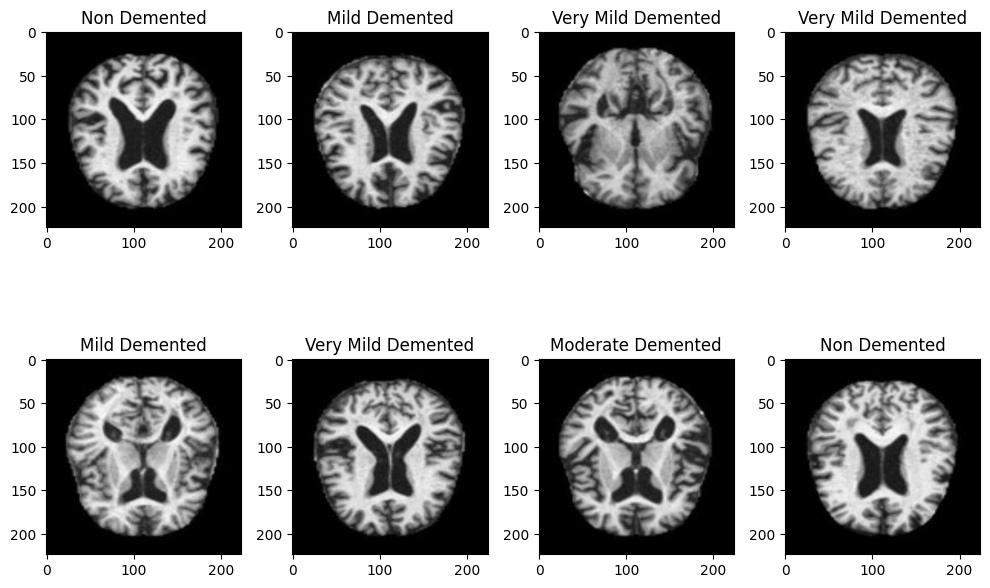

In [21]:
fig, ax = plt.subplots(2, 4, figsize=(10, 7))
axs = ax.flatten()
for axes in axs:
    rand = np.random.randint(0, len(df_train))
    decoded_image = decodificar_imagen(df_train.iloc[rand]['image'])
    axes.imshow(decoded_image, cmap="gray")
    axes.set_title(etiqueta_enfermedad_categoria[df_train.iloc[rand]['label']])
plt.tight_layout()
plt.show()